<a href="https://colab.research.google.com/github/Loumstar/Improving-RoBERTa/blob/master/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar  3 23:05:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup


## Installations & Imports

In [2]:
!pip install transformers sentencepiece ipywidgets tensorboardx wandb
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 3.8 MB 9.7 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 
     |████████████████████████████████| 125 kB 81.4 MB/s 
     |████████████████████████████████| 1.7 MB 85.8 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 6.5 MB 53.3 MB/s 
     |████████████████████████████████| 596 kB 92.5 MB/s 
     |████████████████████████████████| 895 kB 58.5 MB/s 
     |████████████████████████████████| 181 kB 80.0 MB/s 
     |████████████████████████████████| 144 kB 76.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=53152decf1a3137fef46fec6e4b1ad24fad44c8bce2fdc8361fd7929e57bc628
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13


In [3]:
import logging
import string
import wandb
import nltk
import torch

import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from urllib import request

from transformers import Trainer, TrainingArguments
from transformers import DebertaTokenizer, DebertaForSequenceClassification

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from torch.utils.data import DataLoader

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  print("CUDA available.")
  DEVICE = 'cuda:0'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CUDA available.


## Mount Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/'
%mkdir './nlp-cswrk'
%cd './nlp-cswrk' 

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘./nlp-cswrk’: File exists
/content/drive/MyDrive/nlp-cswrk


## Logging

In [6]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Download Datasets

In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv


In [8]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv


In [9]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [10]:
from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

In [11]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

## Pre-processing

### Convert CSVs to Data Frames

In [12]:
train_import = pd.read_csv('train_semeval_parids-labels.csv')
test_import = pd.read_csv('dev_semeval_parids-labels.csv')

In [13]:
train_import.par_id = train_import.par_id.astype(str)
test_import.par_id = test_import.par_id.astype(str)

In [14]:
rows = [] # will contain par_id, label and text
for idx in range(len(train_import)):
  parid = train_import.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
train_df = pd.DataFrame(rows)

In [15]:
rows = [] # will contain par_id, label and text
for idx in range(len(test_import)):  
  parid = test_import.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
  test_df = pd.DataFrame(rows)

### Shuffle Datasets

In [16]:
hyperparameter_tuning = False

In [17]:
train_df = shuffle(train_df)

if hyperparameter_tuning:
    train_df, val_df = train_test_split(train_df, train_size=0.8)

test_df = shuffle(test_df)

## Implementations

### Main Function
Enter iteration number to pre-process data corresponding to the implementation iteration.

In [18]:
def main_implement(implementation_number, train):
    if implementation_number == 1:
        train = downsample_unpat(train)
    elif implementation_number == 2:
        train = downsample_unpat(train)
        train = upsample_pat(train)
    elif implementation_number == 3:
        train = downsample_unpat(train)
        train = lemmatise_df(train)
    elif implementation_number == 4:
        train = add_backtranslations(train)
        train = downsample_unpat(train)
    train.length = train.text.str.split().map(get_list_length)
    return train

In [19]:
def get_list_length(x):
  if type(x) == list:
    return len(x)
  elif x is not None:
    return 1
  else:
    return None

In [20]:
def get_label_ratio(dataset):
    return len(dataset[dataset.label == 0])/len(dataset[dataset.label == 1])

### Implementation 1
Downsample unpatronising data (as in competition's roberta base) (ratio from 9:1 to 3:1).

In [21]:
def downsample_unpat(train):
    pat_train = train[train.label == 1]
    npos = len(pat_train)

    train = pd.concat([pat_train, train[train.label == 0][:npos*3]])
    return train

### Implementation 2
Upsample patronising data

In [22]:
def upsample_pat(train):
    ratio = int(get_label_ratio(train))

    pat_train = train[train.label == 1]
    unpat_train = train[train.label == 0]

    pat_train = pd.concat([pat_train]*ratio)
    train = pd.concat([pat_train, unpat_train])
    
    return train

In [23]:
def df_to_dict_of_lists(df):
    texts = df['text'].values.tolist()
    labels = df['label'].values.tolist()
    parids = df['par_id'].values.tolist()
    keywords = df['keyword'].values.tolist()
    countries = df['country'].values.tolist()
    intensities = df['intensity'].values.tolist()
    lengths = df['length'].values.tolist()
    
    return {
        'texts': texts,
        'labels': labels,
        'parids': parids,
        'keywords': keywords,
        'countries': countries,
        'intensities': intensities,
        'lengths': lengths
    }

### Implementation 3
Lemmatise words in text using verb PoS tagging

In [24]:
lemmatizer = WordNetLemmatizer()

def remove_punctuation(token):
    return not any(map(lambda s: s in string.punctuation, token))

def lemmatise(word):
    return lemmatizer.lemmatize(word, pos="v")

def lemmatise_sentence(sentence):
  tokens = wordpunct_tokenize(sentence)
  tokens = list(map(lemmatise, tokens))
  # tokens = list(filter(remove_punctuation, tokens))

  return " ".join(tokens)

def lemmatise_df(df):
  df.text = df.text.map(lemmatise_sentence)
  
  return df

### Implementation 4
Generate new examples using back-translation (of French and Spanish)



In [25]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv


In [26]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv


In [27]:
backtranslated_cols = ["par_id", "art_id", "category", "country", "text", "score"]

french_import = pd.read_csv('dontpatronizeme_french_backtranslation.csv', names=backtranslated_cols)
spanish_import = pd.read_csv('dontpatronizeme_spanish_backtranslation.csv', names=backtranslated_cols)

In [28]:
# Copy the training dataset and swap out the text 
# for the back-translated version.
french_df = train_df.copy()
french_df.text = french_import.text

spanish_df = train_df.copy()
spanish_df.text = spanish_import.text

def add_backtranslations(df):
  df = df.append(french_df, ignore_index=True, 
                 verify_integrity=True)
  
  df = df.append(spanish_df, ignore_index=True, 
                 verify_integrity=True)
  
  df.length = df.text.str.split().map(get_list_length)
  df.dropna(inplace=True)
  
  return df

### Choose Implementation

In [29]:
train_df = main_implement(3, train_df)

In [30]:
print(get_label_ratio(train_df))

3.0


In [31]:
train_df

,par_id,text,label,keyword,country,intensity,length
81,8228,"About the same time , she give an interview to...",1,hopeless,ca,3,35
197,7407,No right - think person could seriously consid...,1,women,gb,2,116
38,4466,She say these women deserve the same kind of c...,1,women,bd,3,20
143,7637,""" Another fond memory I cherish be the day he ...",1,in-need,ng,4,117
348,935,"In his view , Professor George Gongera , an ex...",1,hopeless,ke,3,36
...,...,...,...,...,...,...,...
8136,8119,There be many philosophical and ethical factor...,0,vulnerable,pk,0,70
5426,5107,One of the victims present at the press confer...,0,in-need,hk,0,27
7982,7950,""""""" The organizers have direct the council to ...",0,homeless,hk,0,24
1147,393,Intelligent individuals will hope to fully dev...,0,hopeless,my,0,34


## More Data Formatting

Convert data to class and create embeddings from tokeniser

In [32]:
class PatroDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set, max_length=128):

        self.tokenizer = tokenizer
        self.texts = input_set['texts']
        self.labels = input_set['labels']
        self.parids = input_set['parids']
        self.keywords = input_set['keywords']
        self.countries = input_set['countries']
        self.intensities = input_set['intensities']
        self.lengths = input_set['lengths']

        self.max_length = max_length

    def collate_fn(self, batch):
        texts, labels = [], []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', 
                                   padding=True, truncation=True, 
                                   max_length=self.max_length)
        
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        return {
            'text': self.texts[idx],
            'label': self.labels[idx],
            'parid': self.parids[idx],
            'keyword': self.keywords[idx],
            'countriy': self.countries[idx],
            'intensity': self.intensities[idx],
            'length': self.lengths[idx]
        }

In [33]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [35]:
trainset = df_to_dict_of_lists(train_df)
testset = df_to_dict_of_lists(test_df)

test_dataset = PatroDataset(tokenizer, testset)

if hyperparameter_tuning:
    valset = df_to_dict_of_lists(val_df)
    val_dataset = PatroDataset(tokenizer, valset)
    val_loader = DataLoader(val_dataset)

## Model

### Hyperparameter Tuning Configuration (using WandB)

In [36]:
if hyperparameter_tuning:
    wandb.login()

    config = {
        "name": "vanilla-sweep",
        "method": "grid",
        "metric": {
            "name": "f1_score",
            "goal": "maximize"
        },
        "parameters": {
            "num_epochs": {
                "values":[3, 4, 5]
            },
            "learning_rate": {
                "values":[1e-4, 1.5e-4, 2e-4]
            },
            "max_length": {
                "values": [64, 128]
            }
        },
        "early_terminate": {"type": "hyperband", "min_iter": 3},
    }

    sweep_id = wandb.sweep(config, project="DeBERTa Hyperparameter Tuning")

### DeBERTa Model & Trainer

In [37]:
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

#180 M
print(f"Model size: {model.num_parameters()}")

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

Model size: 139193858


In [38]:
class Trainer_patronise(Trainer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.losses = []

    def compute_loss(self, model, inputs):
        labels = inputs.pop('label')

        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_task = nn.CrossEntropyLoss()

        loss = loss_task(logits, labels)
        self.losses.append(loss.item())
        
        return loss

### Main Training Funtion (incl. Hyperparameter Search)

In [39]:
def main_patronise():
    if hyperparameter_tuning:
        wandb.init()
        learning_rate = wandb.config.learning_rate
        max_length = wandb.config.max_length
        num_epochs = wandb.config.num_epochs
    else:
        learning_rate = 0.0001
        max_length = 128
        num_epochs = 5

    train_dataset = PatroDataset(tokenizer, trainset,
                                 max_length=max_length)

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
    
    training_args = TrainingArguments(
        output_dir='./',
        learning_rate=learning_rate,
        lr_scheduler_type='linear',
        logging_steps=100,
        per_device_train_batch_size=32,
        num_train_epochs=num_epochs,
        adam_beta1 = 0.9,
        adam_beta2 = 0.999,
        adam_epsilon = 1e-6,
        max_grad_norm = 1.0,
        save_steps = 2500
    )
    trainer = Trainer_patronise(
        model=model,              
        args=training_args,                
        train_dataset=train_dataset,          
        data_collator=train_dataset.collate_fn
    )
    
    trainer.train()
    trainer.save_model('./')

    model = DebertaForSequenceClassification.from_pretrained("./")

    if hyperparameter_tuning:
        report, _ = evaluate(model, tokenizer, val_loader, val_df)
        f1_score = report[1]["f1-score"]

        wandb.log({"f1_score": f1_score})
        wandb.join()

    return trainer.losses

## Evaluation

### Prediction Function

In [40]:
def predict_patronise(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output.logits, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

### Evaluation Function

In [41]:
def evaluate(model, tokenizer, data_loader, test_df):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  test_df['prediction'] = np.nan

  with torch.no_grad():
    for data in tqdm(data_loader):
      labels = {}
      labels['label'] = data['label']

      sentences = data['text']

      pred = predict_patronise(sentences, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      tot_labels.append(labels['label'].tolist())

      for id, data_prediction in zip(data['parid'], pred['prediction']):
        rows = test_df.loc[test_df.par_id == id]
        rows.prediction = data_prediction.tolist()
        test_df.update(rows)

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)

  return report, test_df

## Run Train/Hyperparameter Search

In [42]:
if hyperparameter_tuning:
    losses = wandb.agent(sweep_id, function=main_patronise, count=18)
else:
    losses = main_patronise()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,0.501100
200,0.365500
300,0.222000
400,0.103400
500,0.040900




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin
loading configuration file ./config.json
Model config DebertaConfig {
  "_name_or_path": "microsoft/deberta-base",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0

## Analysis

### Plot Loss Curves

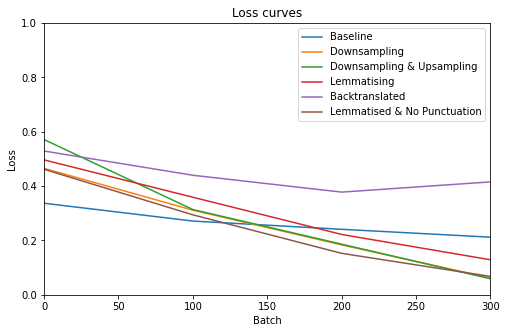

In [43]:
# Recorded loss values for different implementations of the model
baseline_loss = np.array([0.3369, 0.2713, 0.2410, 0.2120, 0.2727, 0.2107, 0.1947])
downsample_loss = np.array([0.4651, 0.3113, 0.1835, 0.0619])
down_upsample_loss = np.array([0.5711, 0.3136, 0.1862, 0.0588])
lemmatised_loss = np.array([0.4964, 0.3589, 0.2220, 0.1288])
backtranslated_loss = np.array([0.5290, 0.4398, 0.3778, 0.4154, 0.3843, 0.3832, 0.3817])
lemmatised_no_punct_loss = np.array([0.4618, 0.2942, 0.1525, 0.0676])

losses = [
    (baseline_loss, "Baseline"),
    (downsample_loss, "Downsampling"),
    (down_upsample_loss, "Downsampling & Upsampling"),
    (lemmatised_loss, "Lemmatising"),
    (backtranslated_loss, "Backtranslated"),
    (lemmatised_no_punct_loss, "Lemmatised & No Punctuation")
]

figure, axis = plt.subplots()


for loss, label in losses:
    batches = np.arange(0, len(loss) * 100, 100)
    axis.plot(batches, loss, label=label)

figure.set_size_inches((8, 5))

axis.set_ylabel("Loss")
axis.set_xlabel("Batch")
axis.set_title("Loss curves")
axis.set_xlim(0, 300)
axis.set_ylim(0, 1)

axis.legend()

plt.show()

### Report F1 Score

In [44]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#your saved model name here
model_name = './'
model = DebertaForSequenceClassification.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

report, annotated_test_dataset = evaluate(model, tokenizer, test_loader, test_df)

print(report)

print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

loading file https://huggingface.co/microsoft/deberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/ce0ac094af27cf80bbf403595a6d47f1fc632981bf1d4c5bf69968568cbea410.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/05056f257c8d2b63ad16fd26f847c9ab9ee34e33cdfad926e132be824b237869.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/microsoft/deberta-base/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c2bc27a1c7529c177696ff76b1e74cba8667be14e202359f20f9114e407f43e2.a39abb1c6179fb264c2db685f9a056b7cb8

  0%|          | 0/2094 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


{0: {'precision': 0.9603305785123967, 'recall': 0.9197889182058048, 'f1-score': 0.939622641509434, 'support': 1895}, 1: {'precision': 0.4551971326164875, 'recall': 0.6381909547738693, 'f1-score': 0.5313807531380753, 'support': 199}, 'accuracy': 0.8930276981852913, 'macro avg': {'precision': 0.7077638555644421, 'recall': 0.778989936489837, 'f1-score': 0.7355016973237547, 'support': 2094}, 'weighted avg': {'precision': 0.912326015124963, 'recall': 0.8930276981852913, 'f1-score': 0.9008260150596249, 'support': 2094}}
0.8930276981852913
0.939622641509434
0.5313807531380753


### Analysis of F1 score with different intensities

In [64]:
def get_test_histograms(df, intensity, axis):
    intensity_df = df.loc[df.intensity.map(int) == intensity]

    intensity_df.prediction \
        .map(lambda x: "Patronising" if int(x) == 1 else "Unpatronising") \
        .hist(bins=[-0.5, 0.5, 1.5], ax=axis, grid=False)

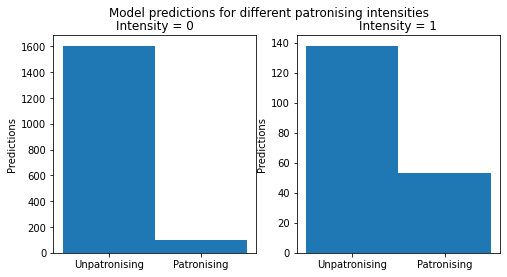

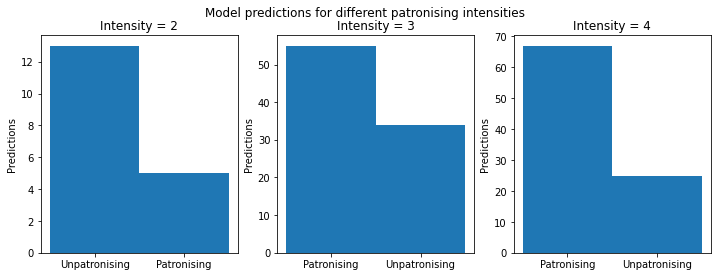

In [67]:
figure_unpatr, (axis0, axis1) = plt.subplots(1, 2)

figure_unpatr.set_size_inches((8, 4))
figure_unpatr.suptitle("Model predictions for different patronising intensities")

axis0.set_ylabel("Predictions")
axis1.set_ylabel("Predictions")

axis0.set_title("Intensity = 0")
axis1.set_title("Intensity = 1")

get_test_histograms(annotated_test_dataset, 0, axis0)
get_test_histograms(annotated_test_dataset, 1, axis1)

figure_patr, (axis2, axis3, axis4) = plt.subplots(1, 3)

figure_patr.set_size_inches(12, 4)
figure_patr.suptitle("Model predictions for different patronising intensities")

axis2.set_ylabel("Predictions")
axis3.set_ylabel("Predictions")
axis4.set_ylabel("Predictions")

axis2.set_title("Intensity = 2")
axis3.set_title("Intensity = 3")
axis4.set_title("Intensity = 4")

get_test_histograms(annotated_test_dataset, 2, axis2)
get_test_histograms(annotated_test_dataset, 3, axis3)
get_test_histograms(annotated_test_dataset, 4, axis4)

In [ ]:
def intensity_f1_score(df):
    f1_scores = list()

    for intensity in range(5):
        intensity_df = df.loc[df.intensity.map(int) == intensity]
        labels = intensity_df.label.tolist()
        predictions = intensity_df.label.tolist()
        
        score = f1_score(labels, predictions)
        f1_scores.append(score)
    
    return f1_scores

"""
def analysis_on_intensities(annotated_dataset):
    scores = []
    for intensity_value in range(0,5):
        subset_dataset = annotated_dataset.loc[annotated_dataset.intensity.map(int) == intensity_value]
        labels = subset_dataset['label'].tolist()
        preds = subset_dataset['prediction'].tolist()
        score = f1_score(labels, preds)
        print(score)
        scores.append(score)
    return scores
"""

In [ ]:
intensity_f1_score(annotated_test_dataset)

### Analysis of F1 score with different input lengths

In [ ]:
def input_length_f1_score(df):
    results = list()
    
    for lb in np.arange(0, 200, 20):
        ub = lb + 20
        input_length_df = df.loc[df.length >= lb & df.length < ub]
        predictions = input_length_df.predictions
        labels = input_length_df.labels

        score = f1_score(labels, predictions)
        results.append((score, f"{lb} <= length < {ub}"))
    
    scores, labels = zip(*results)

    return list(scores), list(labels)

In [ ]:
scores, labels = input_length_f1_score(annotated_test_dataset)

figure, axis = plt.subplots()
figure.set_size_inches((8, 4))

axis.hist(scores, bins=labels)

axis.set_title("Variation of F1 score for examples with different numbers of words")
axis.set_xlabel("Number of words")
axis.set_ylabel("F1 Score")

In [ ]:
"""
def analysis_on_input_size(annotated_dataset):
    for i in range(0,6):
        subset_dataset = annotated_dataset.loc[i*50 <= annotated_dataset.length.map(int) < (i+1)*50]
        


    plt.title("Average Character Length of a sample")
    plt.ylabel("Frequency")
    plt.xlabel("Character Length")

    # series = df["text"].str.len()

    # print(series.max())
    # series.hist(bins=200, figsize=(8, 6))

    # unpatronising_df["text"].str.len().hist(bins=200, alpha=0.5, figsize=(8, 6))
    # patronising_df["text"].str.len().hist(bins=200, alpha=0.5, figsize=(8, 6))

    (unpatcounts, unpatbins) = np.histogram(unpatronising_df["text"].str.len(), bins=100, range=(0, 2000))
    (patcounts, patbins) = np.histogram(patronising_df["text"].str.len(), bins=100, range=(0, 2000))

    factor = 1/len(unpatronising_df["text"])
    plt.hist(unpatbins[:-1], unpatbins, weights=factor*unpatcounts, alpha=0.6)

    factor = 1/len(patronising_df["text"])
    plt.hist(patbins[:-1], patbins, weights=factor*patcounts, alpha=0.6)

    plt.xlim((0, 2000))
"""

### Analysis of F1 score with different categories

In [ ]:
def categories_f1_score(df):
    results = list()
    
    for category in np.unique(df.keyword):
        category_df = df.loc[df.keyword == category]
        predictions = category_df.predictions
        labels = category_df.labels

        score = f1_score(labels, predictions)
        results.append((score, category))
    
    scores, labels = zip(*results)

    return list(scores), list(labels)

In [ ]:
scores, labels = categories_f1_score(annotated_test_dataset)

figure, axis = plt.subplots()
figure.set_size_inches((8, 4))

axis.hist(scores, bins=labels)

axis.set_title("Variation of F1 score with category")
axis.set_xlabel("Category")
axis.set_ylabel("F1 Score")